In [144]:
import torch, torchvision
import matplotlib.pyplot as plt
import DVNET_Utilities

image_net_transform_nocrop = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

ImageNet = torchvision.datasets.ImageFolder("/cifs/data/tserre_lrs/projects/projects/prj_hmax/data/ILSVRC/train",transform=image_net_transform_nocrop)
train_dataloader = torch.utils.data.DataLoader(ImageNet,shuffle=True,batch_size=1)

torch.cuda.is_available()

False

torch.Size([1, 3, 361, 430])
tensor(170.)
tensor(195.)
tensor(208.)
tensor(287.)


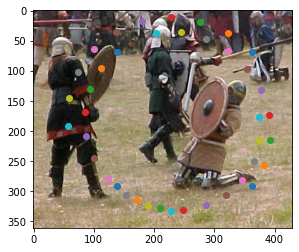

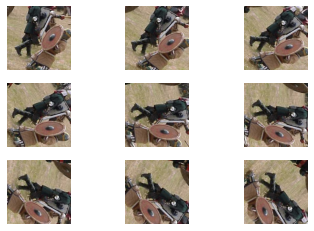

In [147]:
image,label = next(iter(train_dataloader))
sequence_length = 10

print(image.size())

size_dim_1 = image.size()[2]
size_dim_2 = image.size()[3]

# Goal is to create transformation sequences
# Origin = center of original patch (for scaling purposes, otherwise scale varies with patch location)
# (1) Create affine transformation matrix
maximum_translation = 5  # Pixels, +/-
maximum_rotation    = 30 # Degrees, +/-
maximum_scale       = 3  # Percent, +/-
maximum_shear       = 2  # Percent, +/-

affine_translate = maximum_translation*(2*torch.rand(2)-1)
affine_rotation = torch.deg2rad(maximum_rotation*(torch.rand(1)*2-1))
affine_scale = 1.0 + (maximum_scale/100.0)*(2*torch.rand(2)-1)
affine_shear = (maximum_shear/100.0)*(2*torch.rand(2)-1)

A_tr = torch.zeros((3,3), requires_grad=False)
A_tr[0,2] = affine_translate[0]
A_tr[1,2] = affine_translate[1]
A_tr[0,0] = 1.0
A_tr[1,1] = 1.0
A_tr[2,2] = 1.0

A_ro = torch.zeros((3,3), requires_grad=False)
A_ro[0,0] =  torch.cos(affine_rotation)
A_ro[0,1] = -torch.sin(affine_rotation)
A_ro[1,0] =  torch.sin(affine_rotation)
A_ro[1,1] =  torch.cos(affine_rotation)
A_ro[2,2] = 1.0

A_sc = torch.zeros((3,3), requires_grad=False)
A_sc[0,0] = affine_scale[0]
A_sc[1,1] = affine_scale[1]
A_sc[2,2] = 1.0

A_sh = torch.zeros((3,3), requires_grad=False)
A_sh[0,0] = 1.0
A_sh[0,1] = affine_shear[0]
A_sh[1,0] = affine_shear[1]
A_sh[1,1] = 1.0
A_sh[2,2] = 1.0

A = torch.matmul(A_tr,A_ro)
A = torch.matmul(A,A_sc)
A = torch.matmul(A,A_sh)

square_coord = torch.ones(3,4)
image_crop_length = 224
image_crop_half_length = (image_crop_length-1)/2
square_coord[0,0] = -image_crop_half_length
square_coord[1,0] =  image_crop_half_length
square_coord[0,1] =  image_crop_half_length
square_coord[1,1] =  image_crop_half_length
square_coord[0,2] = -image_crop_half_length
square_coord[1,2] = -image_crop_half_length
square_coord[0,3] =  image_crop_half_length
square_coord[1,3] = -image_crop_half_length

out_coord = torch.zeros((3,4,10), requires_grad=False)
out_coord[:,:,0] = square_coord
for i in range(sequence_length-1):
    out_coord[:,:,i+1] = torch.matmul(A,out_coord[:,:,i])

# Find bounding-box containing all transformation coordinates, and use this to randomly but validly place the transformation
min_valid_dim1 = 1-torch.floor(torch.min(out_coord[0,:,:]))
max_valid_dim1 = size_dim_1-torch.ceil(torch.max(out_coord[0,:,:]))
min_valid_dim2 = 1-torch.floor(torch.min(out_coord[1,:,:]))
max_valid_dim2 = size_dim_2-torch.ceil(torch.max(out_coord[1,:,:]))

# TODO some images are too small, need to recognize and discard sample
print(min_valid_dim1)
print(min_valid_dim2)
print(max_valid_dim1)
print(max_valid_dim2)
if(max_valid_dim1 < min_valid_dim1 or max_valid_dim2 < min_valid_dim2):
    print("WARNING: Image is too small to fit expected transformation sequence.")

offset = torch.rand(2)

out_coord[0,:,:] = out_coord[0,:,:] + min_valid_dim1 + offset[0]*(max_valid_dim1-min_valid_dim1)
out_coord[1,:,:] = out_coord[1,:,:] + min_valid_dim2 + offset[1]*(max_valid_dim2-min_valid_dim2)

# Show affine transformation point series
plt.imshow(image[0,:,:,:].permute((1,2,0)))
for i in range(sequence_length):
    plt.scatter(out_coord[1,:,i],out_coord[0,:,i])
plt.show()

# For each transformation point will interpolate image... need to recompute with the full
# meshgrid instead of just corners.
transformation_sequence = torch.zeros(10,3,image_crop_length,image_crop_length)
input_grid = torch.meshgrid(torch.linspace(-image_crop_half_length,image_crop_half_length,image_crop_length),
                            torch.linspace(-image_crop_half_length,image_crop_half_length,image_crop_length))
input_grid_2d = torch.ones((3,image_crop_length*image_crop_length))
for i in range(2):
    input_grid_2d[i,:] = torch.reshape(input_grid[i],(1,image_crop_length*image_crop_length))

fig,axs = plt.subplots(3,3)
for i in range(sequence_length):
    sample_points = torch.zeros((1,image_crop_length,image_crop_length,2))

    sample_points[:,:,:,1] = torch.reshape(input_grid_2d[0,:] + min_valid_dim1 + offset[0]*(max_valid_dim1-min_valid_dim1),(1,image_crop_length,image_crop_length)) 
    sample_points[:,:,:,0] = torch.reshape(input_grid_2d[1,:] + min_valid_dim2 + offset[1]*(max_valid_dim2-min_valid_dim2),(1,image_crop_length,image_crop_length)) 
    
    sample_points[:,:,:,1] = (sample_points[:,:,:,1] / image.size()[2])*2 - 1
    sample_points[:,:,:,0] = (sample_points[:,:,:,0] / image.size()[3])*2 - 1

    image_patch = torch.nn.functional.grid_sample(image,sample_points)
    input_grid_2d = torch.matmul(A,input_grid_2d)
    if(i>0):
        axs[(i-1)//3,(i-1)%3].imshow(image_patch[0,:,:,:].permute((1,2,0)))
        axs[(i-1)//3,(i-1)%3].axis('off')


